<a href="https://colab.research.google.com/github/mini12347/British_Airlines_Project/blob/main/Deep_Project_ML_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,f1_score,make_scorer
from transformers import BertTokenizer, BertModel,RobertaTokenizer, RobertaModel
import torch
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import plotly.express as px
from nltk.tokenize import TweetTokenizer
import emoji
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from sklearn.ensemble import StackingClassifier
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
df = pd.read_csv('/content/train.En.csv', index_col=0)

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text=text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)

    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)

    text = ' '.join(text.split())

    return text

df['tweet_clean'] = df['tweet'].apply(clean_text)
df[['tweet', 'tweet_clean']].head()

,tweet,tweet_clean
0,The only thing I got from college is a caffein...,the only thing i got from college is a caffein...
1,I love it when professors draw a big question ...,i love it when professors draw a big question ...
2,Remember the hundred emails from companies whe...,remember the hundred emails from companies whe...
3,Today my pop-pop told me I was not “forced” to...,today my pop-pop told me i was not “forced” to...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,"i did too, and i also reported cancun cruz not..."


In [ ]:
X = df['tweet_clean']
y = df['sarcastic']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.eval()
roberta_model.to(device)

def get_roberta_embedding_batch(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = roberta_model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

print("Extracting RoBERTa embeddings for training set...")
X_train_roberta = get_roberta_embedding_batch(X_train.tolist(), batch_size=32)

print("Extracting RoBERTa embeddings for validation set...")
X_val_roberta = get_roberta_embedding_batch(X_val.tolist(), batch_size=32)

print(f"Train embeddings shape: {X_train_roberta.shape}")
print(f"Val embeddings shape: {X_val_roberta.shape}")



Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting RoBERTa embeddings for training set...


100%|██████████| 87/87 [00:14<00:00,  6.14it/s]


Extracting RoBERTa embeddings for validation set...


100%|██████████| 22/22 [00:02<00:00,  8.51it/s]

Train embeddings shape: (2774, 768)
Val embeddings shape: (694, 768)


In [ ]:
scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_roberta)
X_test_feat_scaled = scaler.transform(X_val_roberta)

X_train_combined = np.hstack([X_train_roberta, X_train_feat_scaled])
X_test_combined = np.hstack([X_val_roberta, X_test_feat_scaled])

In [ ]:
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_combined, y_train)

In [ ]:
! pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LeakyReLU,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.backend import clear_session
import tensorflow as tf
import numpy as np

def create_model(input_dim, dropout_rate=0.5, learning_rate=1e-3):
    model = Sequential([
        Dense(512, input_dim=input_dim, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(256, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(128, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(64, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')
    ])
    return model

input_dim = X_train_balanced.shape[1]
model = create_model(input_dim, dropout_rate=0.4)
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        w = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        loss = -w * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return loss

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=focal_loss(gamma=3, alpha=0.25),
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

print("\nModel Summary:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963,329 (3.67 MB)

 Trainable params: 961,409 (3.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    mode='min',
    verbose=1
)


history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9817 - auc: 0.9988 - loss: 0.0025 - precision: 0.9982 - recall: 0.9572 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 6.0325e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-04
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9857 - auc: 0.9997 - loss: 0.0019 - precision: 0.9977 - recall: 0.9678 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 5.6699e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-04
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9861 - auc: 0.9994 - loss: 0.0019 - precision: 0.9983 - recall: 0.9677 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 3.3576e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-04
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9907 - auc: 0.9996 - loss: 0.0015 - precision: 0.9925 - recall: 0.9844 - val_accuracy: 1.0000 -

In [ ]:
loss, accuracy, precision, recall, auc = model.evaluate(X_test_combined, y_val, verbose=0)
print(f"\nValidation Metrics:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1-Score: {2 * (precision * recall) / (precision + recall):.4f}")

from sklearn.metrics import f1_score
probs = model.predict(X_test_combined)
best_t, best_f1 = 0.5, 0
for t in np.linspace(0.1,0.9,81):
    f = f1_score(y_val, probs >= t)
    if f > best_f1:
        best_f1, best_t = f, t
print(best_t, best_f1)
y_pred = (probs > best_t).astype(int)


Validation Metrics:
Loss: 0.1312
Accuracy: 0.7363
Precision: 0.4479
Recall: 0.2486
AUC: 0.6449
F1-Score: 0.3197
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.11 0.44834307992202727


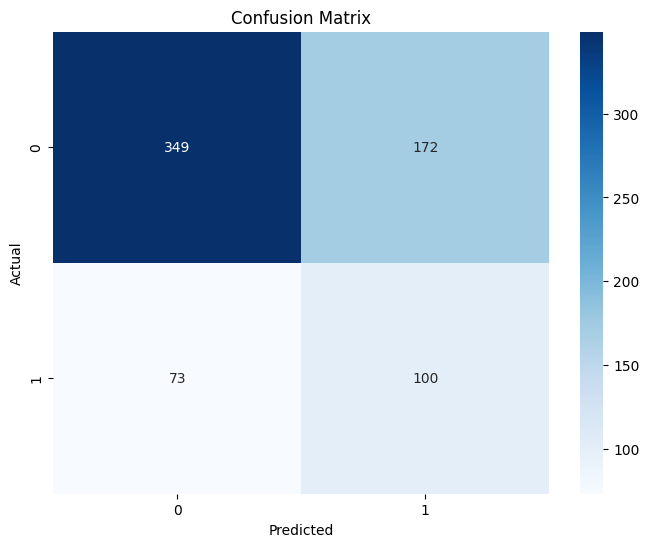

In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74       422
           1       0.58      0.37      0.45       272

    accuracy                           0.65       694
   macro avg       0.62      0.60      0.59       694
weighted avg       0.63      0.65      0.63       694



> Ensemble Approach

In [ ]:
from sklearn.metrics import precision_score,recall_score
def train_ensemble(n_models=5):
    models = []
    print(f"\nTraining ensemble of {n_models} models...")

    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models}...")
        np.random.seed(42 + i)
        tf.random.set_seed(42 + i)
        model = create_improved_model(input_dim, dropout_rate=0.4)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )
        history = model.fit(
            X_train_balanced,
            y_train_balanced,
            validation_split=0.15,
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        models.append(model)
        final_metrics = history.history
        print(f"Model {i+1} - Final val_loss: {final_metrics['val_loss'][-1]:.4f}, "
              f"val_accuracy: {final_metrics['val_accuracy'][-1]:.4f}")
    return models

def ensemble_predict(models, X, verbose=True):
    if verbose:
        print(f"Making predictions with {len(models)} models...")

    predictions = []
    for i, model in enumerate(models):
        if verbose:
            print(f"Model {i+1}/{len(models)} predicting...")
        pred = model.predict(X, verbose=0)
        predictions.append(pred)


    avg_predictions = np.mean(predictions, axis=0)

    if verbose:
        print("Ensemble predictions complete!")

    return avg_predictions


ensemble_models = train_ensemble(n_models=5)

print("\n" + "="*50)
print("ENSEMBLE EVALUATION")
print("="*50)


ensemble_probs = ensemble_predict(ensemble_models, X_test_combined)


print("\nFinding optimal threshold...")
best_threshold = 0.5
best_f1 = 0

for threshold in np.linspace(0.1, 0.9, 81):
    y_pred_temp = (ensemble_probs >= threshold).astype(int).ravel()
    f1 = f1_score(y_val, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1-score: {best_f1:.4f}")


y_pred_ensemble = (ensemble_probs >= best_threshold).astype(int).ravel()

print("\n" + "="*50)
print("ENSEMBLE PERFORMANCE METRICS")
print("="*50)

accuracy = accuracy_score(y_val, y_pred_ensemble)
precision = precision_score(y_val, y_pred_ensemble)
recall = recall_score(y_val, y_pred_ensemble)
f1 = f1_score(y_val, y_pred_ensemble)

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")




Training ensemble of 5 models...

Training model 1/5...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - accuracy: 0.5360 - auc: 0.5292 - loss: 0.9004 - precision: 0.4569 - recall: 0.5023 - val_accuracy: 0.4776 - val_auc: 0.0000e+00 - val_loss: 0.8477 - val_precision: 1.0000 - val_recall: 0.4776 - learning_rate: 0.0010
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6407 - auc: 0.6701 - loss: 0.6749 - precision: 0.5834 - recall: 0.5298 - val_accuracy: 0.7708 - val_auc: 0.0000e+00 - val_loss: 0.4971 - val_precision: 1.0000 - val_recall: 0.7708 - learning_rate: 0.0010
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6908 - auc: 0.7474 - loss: 0.6007 - precision: 0.6496 - recall: 0.5880 - val_accuracy: 0.8542 - val_auc: 0.0000e+00 - val_loss: 0.3752 - val_precision: 1.0000 - val_recall: 0.8542 - learning_rate: 0.0010
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7424 - auc: 0.8063 - loss: 0.5415 - precision: 0.7113 - recall: 0.6603 - val_accuracy: 0.9006 - val_auc: 0.0000e+00 - va

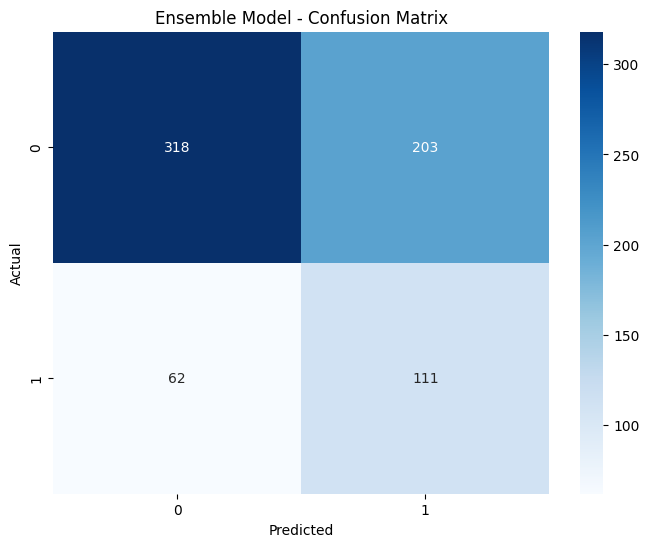

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Model - Confusion Matrix')
plt.show()




In [ ]:

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_val, y_pred_ensemble, target_names=['Not Sarcastic', 'Sarcastic']))


DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

Not Sarcastic       0.84      0.61      0.71       521
    Sarcastic       0.35      0.64      0.46       173

     accuracy                           0.62       694
    macro avg       0.60      0.63      0.58       694
 weighted avg       0.72      0.62      0.64       694

